In [ ]:
import numpy as np
import pandas

import sklearn
import sklearn.metrics
from sklearn.preprocessing import MultiLabelBinarizer

import nltk
from nltk.stem import PorterStemmer
import pandas as pd
import math

import os
import regex
import copy
import string
import random

# Part 1

these aspects are most viewd / cared about by the viewers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read in sentences from aspect_sentence

In [ ]:
base_root = "/content/drive/MyDrive/aspect_sentence/aspect_sentence_train/"
# base_root = "/content/drive/MyDrive/aspect_sentence_train+test/"

In [ ]:
actor_root = base_root + "actor_sentence_final.txt"
facility_root = base_root + "facility_sentence.txt"
plot_root = base_root + "plot_sentence_final.txt"
scene_root = base_root + "scene_sentence_final.txt"
# actor_root = base_root + "train_test_actor_sentence_use.txt"
# facility_root = base_root + "train_test_facility_sentence_final.txt"
# plot_root = base_root + "train_test_plot_sentence.txt"
# scene_root = base_root + "train_test_scene_sentence.txt"

files_root = [actor_root, facility_root, plot_root, scene_root]

In [ ]:
# make sentence number same in each aspect
file_len_list = [len(open(root,"r").readlines()) for root in files_root]
min_len = min(file_len_list)
min_len
# so each category read 1039 aspects comments

1039

In [ ]:
# make same foramt for preprocessing
# dict : key: cid, value: [sentene, score label]
sentence_4_aspects = [dict() for i in range(len(files_root))]

# import pandas as pd
for i in range(len(files_root)):
  with open(files_root[i],"r") as file:
    line_493 = [line.strip("\n") for line in file.readlines()[:min_len]]
    # df = pd.DataFrame(line_493)
    # df.to_csv(str(i)+".csv",index=False)
    for id in range(len(line_493)):
      # assign id manually
      sentence_4_aspects[i][id] = [line_493[id],"_"]
  

In [ ]:
all_aspect_sentence = []

for sent_collection in sentence_4_aspects:
  for sent_id in sent_collection.values():
    all_aspect_sentence.append(sent_id[0])

export for human annotation

In [ ]:
# also draw 5% each from category to human annotate
list_df = list()
aspects = ["actor", "facility", "plot", "scene"]
for i in range(4):
  part = all_aspect_sentence[i*min_len:min_len*(1+i)]
  percent_5 = random.sample(part,k=int(min_len*4*0.05))
  df = pd.DataFrame(percent_5,columns=["sentence"])
  df["answer"] = aspects[i]
  list_df.append(df)

output_df = pd.concat(list_df)

# shuffle
output_df = output_df.sample(frac=1).reset_index(drop=True)

# make file
output_df.to_csv("aspect_annotation.csv")
output_df.head()

,sentence,answer
0,The director did an excellent job of portrayin...,plot
1,I felt like I was inside the action.,scene
2,The characters in the film were very well play...,facility
3,The characters in this movie were so well deve...,plot
4,I was surprised by the amount of emotion the a...,actor


# Read in sentences from train, test


In [ ]:
base_root = "/content/drive/MyDrive/aclImdb/"

In [ ]:
# all dir spec
train_pos_dir = base_root + "train/pos"
test_pos_dir = base_root + "test/pos"
train_neg_dir = base_root + "train/neg"
test_neg_dir = base_root + "test/neg"
all_dir = [train_pos_dir,test_pos_dir,train_neg_dir,test_neg_dir]

# iterate all file names
train_pos_file_list = list()
test_pos_file_list = list()
train_neg_file_list = list()
test_neg_file_list = list()
all_file_list = [train_pos_file_list,test_pos_file_list,train_neg_file_list,test_neg_file_list]

for i in range(len(all_dir)):
  for filename in os.listdir(all_dir[i]):
    f_loc = os.path.join(all_dir[i], filename)
    all_file_list[i].append(f_loc)

[[id]_[rating].txt] where [id] is a unique id and [rating] is
the star rating for that review on a 1-10 scale. For example, the file
[test/pos/200_8.txt] is the text for a positive-labeled test set
example with unique id 200 and star rating 8/10 from IMDb

In [ ]:
# read in sentences
# read in their labels
# dict : key: cid, value: [sentene, score label]
train_pos_sentence_dict = dict()
test_pos_sentence_dict = dict()
train_neg_sentence_dict = dict()
test_neg_sentence_dict = dict()
all_dict_info = [train_pos_sentence_dict,test_pos_sentence_dict,train_neg_sentence_dict,test_neg_sentence_dict]

for i in range(len(all_file_list)):
  count = 0
  for file_loc in all_file_list[i]:

    sentence = open(file_loc,"r").read().strip()
    
    try:
      id_score = regex.findall("/[0-9]*_[0-9]*.txt",file_loc)[0] # ['/11500_10.txt']
    except Exception:
      continue
    else:
      id, score = id_score.lstrip("/").rstrip(".txt").split("_") #['11500', '10']
    
      all_dict_info[i][id] = [sentence, score]
      
    # deal with sample data
      count += 1

    # need more aspect for evaluation
    if count == 1000:
      break

In [ ]:
all_raw_sentence = []

for sent_collection in all_dict_info:
  for sent_id in sent_collection.values():
    all_raw_sentence.append(sent_id[0])

In [ ]:
all_raw_sentence[0]

"If Mulder was looking for his real father here he is Darren McGavin, the first X Files, pity it was only one season long the producers of this show didn't know that they had the makings of a classic on their hands and in 1993 along came Chris Carter with what i call the follow up to the Night Stalker, The X Files. Both will go down as classics is my opinion the two shows taking the viewers to a level of experience that only comes along once in a while and who should appear in the X Files years later Darren McGavin, as Agent Arthur Dales helping our two favorite hero,s solving cases. Paying homage to the man i think so, well done Chris Carter bringing back a forgotten TV show in the form of David Duchovny as Darren McGavin if it wasn't for watching The X files and that particular show i would have never known about the Night Stalker."

In [ ]:
len(all_raw_sentence)

4000

In [ ]:
# use this to generate evaluation aspects

# import pandas as pd
# df = pd.DataFrame(all_raw_sentence)
# df.to_csv("for_evaluation.csv",index=False)

# Sentence preprocessing

remove stopwords, lowercase, remove punctuation, remove_html 
tags, NLTK stemmed version of words, etc.

In [ ]:
# try export to file avoid duplicate runs

In [ ]:
# stop words
closed_class_stop_words = ['a','the','an','and','or','but','about','above','after','along','amid','among',\
              'as','at','by','for','from','in','into','like','minus','near','of','off','on',\
              'onto','out','over','past','per','plus','since','till','to','under','until','up',\
              'via','vs','with','that','can','cannot','could','may','might','must',\
              'need','ought','shall','should','will','would','have','had','has','having','be',\
              'is','am','are','was','were','being','been','get','gets','got','gotten',\
              'getting','seem','seeming','seems','seemed',\
              'enough', 'both', 'all', 'your' 'those', 'this', 'these', \
              'their', 'the', 'that', 'some', 'our', 'no', 'neither', 'my',\
              'its', 'his' 'her', 'every', 'either', 'each', 'any', 'another',\
              'an', 'a', 'just', 'mere', 'such', 'merely' 'right', 'no', 'not',\
              'only', 'sheer', 'even', 'especially', 'namely', 'as', 'more',\
              'most', 'less' 'least', 'so', 'enough', 'too', 'pretty', 'quite',\
              'rather', 'somewhat', 'sufficiently' 'same', 'different', 'such',\
              'when', 'why', 'where', 'how', 'what', 'who', 'whom', 'which',\
              'whether', 'why', 'whose', 'if', 'anybody', 'anyone', 'anyplace', \
              'anything', 'anytime' 'anywhere', 'everybody', 'everyday',\
              'everyone', 'everyplace', 'everything' 'everywhere', 'whatever',\
              'whenever', 'whereever', 'whichever', 'whoever', 'whomever', 'he',\
              'him', 'his', 'her', 'she', 'it', 'they', 'them', 'its', 'their','theirs',\
              'you','your','yours','me','my','mine','i','we','us','much','and/or',\
              "do","does","did"        
              ]

# punctuations
puncs = list(string.punctuation)

# numbers
nums = [i for i in range(10)]

In [ ]:
# diction input is all sentence in one aspect / train_pos.. etc.
from nltk.stem import PorterStemmer
ps = PorterStemmer()

# this is inplace preprocessing
def sentence_preprocess(diction):
  for id in diction.keys():
    sentence, _ = diction[id] # sent, score

    # make lower case and replace all "",'' first : "word"
    # remove HTML tags
    sent = sentence.lower().replace("\"","").replace("\'","").replace("\\","")
    sent = regex.sub(r'<.*?>', '',sent)
    sent_token = sent.split(" ")

    # remove stop words and puncs and nums and combinations and punc in tokens
    processed_token_list = []
    for token in sent_token:
      # nothing
      if 0 <= len(token) <= 1:
        continue
      # numeric
      elif token.isnumeric():
        continue
      # if is punc or contain punc in token
      elif len(set(token).intersection(set(puncs))) != 0:
        continue
      # finally all stop words 
      elif token in closed_class_stop_words:
        continue
      else:
        processed_token_list.append(token)
    
    # # make stemmed version
    processed_token_list = [ps.stem(token) for token in processed_token_list]

    diction[id] = [processed_token_list, _]

start process...

In [ ]:
# preprocess for train . test，
# save copy for unprocessed
train_test_prepro = copy.deepcopy(all_dict_info)

for diction in train_test_prepro:
  sentence_preprocess(diction)

In [ ]:
# example of cleaned output -- relatively clean
train_test_prepro[0]["11764"]

[['saw',
  'theater',
  'fell',
  'chair',
  'laugh',
  'than',
  'know',
  'best',
  'damn',
  'basebal',
  'player',
  'ever',
  'know',
  'go',
  'end',
  'great',
  'time',
  'train',
  'scene',
  'veri',
  'funni',
  'best',
  'scene',
  'one',
  'jack',
  'reno',
  'attempt',
  'watch',
  'falcon',
  'vike',
  'monday',
  'night',
  'footbal',
  'game',
  'while',
  'attempt',
  'dinner',
  'russel',
  'lot',
  'fun',
  'one',
  'bad',
  'overlook',
  'top',
  'notch'],
 '10']

In [ ]:
# preprocess for aspects sentences
aspects_4_prepro = copy.deepcopy(sentence_4_aspects)

for diction in aspects_4_prepro:
  sentence_preprocess(diction)

In [ ]:
aspects_4_prepro[0][100]

[['charact', 'film', 'way', 'stay', 'long', 'movi'], '_']

# Part 2

# TFIDF Feature

In [ ]:
# get all sentences

def get_all_sentence_only(list_diction):
  sentence_4_list = [list() for i in range(len(list_diction))]

  for i in range(len(list_diction)):
    for key in list_diction[i].keys():
      sentence_4_list[i].append(list_diction[i][key][0])
    
  return sentence_4_list

In [ ]:
# all sentence for train/ test
sentence_traintest_list = get_all_sentence_only(train_test_prepro)

# all sent for aspects
sentence_aspect_list = get_all_sentence_only(aspects_4_prepro)

**TF**

In [ ]:
# q collection: 
def get_TF(queries_collection):
    # each element inside is a query frequency dict
    TF_list = []
    # IDF |for word in the query
    for query in queries_collection:
        query_length = len(query)
        q_freq_dict = dict()
        q_set = set(query)
        for token in q_set:
            freq = query.count(token)
            q_freq_dict[token] = math.log2(freq/query_length)
        TF_list.append(q_freq_dict)
    return TF_list

In [ ]:
# create all tf -- [[{term:tf,term:tf},{},...]*4]
tf_sentence_4_list = []

for i in range(4):
  TF_list = get_TF(sentence_traintest_list[i])
  tf_sentence_4_list.append(TF_list)

In [ ]:
tf_sentence_4_list[0][0]

{'season': -6.22881869049588,
 'watch': -6.22881869049588,
 'classic': -5.22881869049588,
 'follow': -6.22881869049588,
 'here': -6.22881869049588,
 'viewer': -6.22881869049588,
 'father': -6.22881869049588,
 'call': -6.22881869049588,
 'real': -6.22881869049588,
 'piti': -6.22881869049588,
 'bring': -6.22881869049588,
 'mcgavin': -6.22881869049588,
 'know': -6.22881869049588,
 'well': -6.22881869049588,
 'come': -6.22881869049588,
 'produc': -6.22881869049588,
 'two': -5.22881869049588,
 'known': -6.22881869049588,
 'one': -6.22881869049588,
 'long': -6.22881869049588,
 'show': -4.22881869049588,
 'done': -6.22881869049588,
 'arthur': -6.22881869049588,
 'solv': -6.22881869049588,
 'onc': -6.22881869049588,
 'forgotten': -6.22881869049588,
 'david': -6.22881869049588,
 'make': -6.22881869049588,
 'back': -6.22881869049588,
 'form': -6.22881869049588,
 'later': -6.22881869049588,
 'look': -6.22881869049588,
 'think': -6.22881869049588,
 'wasnt': -6.22881869049588,
 'mulder': -6.2288186

In [ ]:
tf_sentence_aspect_list = []

for i in range(4):
  TF_list = get_TF(sentence_aspect_list[i])
  tf_sentence_aspect_list.append(TF_list)

In [ ]:
tf_sentence_aspect_list[0][0]

{'prove': -3.0,
 'believ': -3.0,
 'good': -3.0,
 'film': -3.0,
 'actor': -3.0,
 'cant': -3.0,
 'wrong': -3.0,
 'lead': -3.0}

**IDF**

In [ ]:
def get_IDF(queries_collection):
    num_query = len(queries_collection)
    # get all unique words
    IDF_list = []
    for query in queries_collection:
      q_word_freq = {word:0 for word in query}
      for word in query:
        for query_other in queries_collection:
          if word in query_other:
            q_word_freq[word] += 1
      q_word_freq_return = {word:math.log2(num_query/value) for word, value in q_word_freq.items()}
      IDF_list.append(q_word_freq_return)
    return IDF_list

In [ ]:
# create all idf -- [[{term:idf,term:idf},{},...]*4]
idf_sentence_4_list = []

for i in range(4):
  IDF_list = get_IDF(sentence_traintest_list[i])
  idf_sentence_4_list.append(IDF_list)

In [ ]:
idf_sentence_4_list[0][0]

{'mulder': 9.965784284662087,
 'look': 2.077041035763828,
 'real': 2.8059129478836975,
 'father': 4.473931188332412,
 'here': 3.22431729826094,
 'darren': 5.380821783940931,
 'first': 2.0528949484321255,
 'piti': 7.158429362604483,
 'one': 0.9461935563042062,
 'season': 5.573466861883327,
 'long': 3.3075728019102923,
 'produc': 4.380821783940931,
 'show': 0.24468509595490193,
 'didnt': 3.3510744405468786,
 'know': 2.300448367476911,
 'make': 1.5063526660247897,
 'classic': 2.736965594166206,
 'hand': 4.411195432984449,
 'came': 3.795859283219775,
 'chri': 4.107803289534515,
 'carter': 7.380821783940931,
 'call': 3.8996950942043145,
 'follow': 3.9885043611621707,
 'night': 2.6803820657998387,
 'go': 2.2584251525812045,
 'down': 3.2108967824986188,
 'opinion': 5.158429362604483,
 'two': 1.4266254735540556,
 'take': 2.272297327162762,
 'viewer': 3.7563309190331373,
 'level': 5.321928094887363,
 'experi': 4.795859283219775,
 'come': 2.343732465205711,
 'onc': 3.5063526660247897,
 'while': 

In [ ]:
idf_sentence_aspect_list = []

for i in range(4):
  IDF_list = get_IDF(sentence_aspect_list[i])
  idf_sentence_aspect_list.append(IDF_list)

In [ ]:
idf_sentence_aspect_list[0][0]

{'cant': 6.8510549374619,
 'believ': 5.699051844016849,
 'good': 3.594715184202114,
 'lead': 2.61158900276651,
 'actor': 1.2998807501970266,
 'film': 2.144462992339212,
 'prove': 7.436017438183056,
 'wrong': 10.020979938904212}

**TFIDF**

In [ ]:
## tfidf
def create_tfidf(tf_sentence_4_list, idf_sentence_4_list):
  # tf_idf the same structure as tf/idf
  tfidf_4_list = copy.deepcopy(tf_sentence_4_list)

  for i in range(len(tf_sentence_4_list)):  # get train pos -- only 4
    for j in range(len(tf_sentence_4_list[i])):  # get sent
      keys = list(tf_sentence_4_list[i][j].keys())
      # extract aligned tf and idf
      value_tf = np.array([tf_sentence_4_list[i][j][key] for key in keys])
      value_idf = np.array([idf_sentence_4_list[i][j][key] for key in keys])

      value_tfidf = value_tf*value_idf

      # update tfidf dict
      tfidf_4_list[i][j] = {keys[key_index]: value_tfidf[key_index] for key_index in range(len(keys))}
      
  return tfidf_4_list

In [ ]:
# not slow
tfidf_traintest = create_tfidf(tf_sentence_4_list, idf_sentence_4_list)
tfidf_aspect = create_tfidf(tf_sentence_aspect_list, idf_sentence_aspect_list)

## Evaluation preparation

In [ ]:
# read in evaluation dataset
root = "/content/drive/MyDrive/aspect_evaluation/evaluation_final.txt"
eval_file = open(root,"r")

lines = eval_file.readlines()[:] # when 400 [1:-1]
lines = [line.strip().lower().lstrip("[").rstrip("]").split(", ") for line in lines]
lines = [[item.lstrip("'").rstrip("'") for item in line] for line in lines]
print(lines[208])
print(len(lines))

# rewording
new_lines = list()
for item in lines:
  temp_list = list()
  for aspect in item:
    if "actor" in aspect:
      temp_list.append("actor")
    elif "plots" in aspect:
      temp_list.append("plot")
    elif "facility" in aspect:
      temp_list.append("facility")
    elif "special" in aspect:
      temp_list.append("scene")
    else:
      temp_list.append("others")
  new_lines.append(temp_list)

print("----")
print(new_lines[208])
corresponding_aspect = new_lines
# others, movie plots, actor & actress performance, movie special efftes or stage design, movie threater facility

['movie plots']
4000
----
['plot']


In [ ]:
def score_f1(baseline_df, answer = new_lines):
  # use f1 to measure output
  output = [[value] for value in list(baseline_df["category"].values)]

  output = MultiLabelBinarizer().fit_transform(output)
  answers = MultiLabelBinarizer().fit_transform(answer)

  # f1 score
  score = sklearn.metrics.f1_score(answers,output,average="weighted")
  return score

## Basic apporach: Part 1

Simple cosine similarity classification between single sentences. 
4000 movie review sentence * 4156 aspect sentence. (Feature 
problem occurs)


In [ ]:
# based each sentences from train / test, form tfidf vector for each aspect sentence
# then cos on four aspects, find max(mean_score) --> assign label

# get all tfidf in a big list as list contian dict
all_traintest_tfidf = list()
for i in range(len(tfidf_traintest)):
  all_traintest_tfidf.extend(tfidf_traintest[i])

all_aspect_tfidf = list()
for i in range(len(tfidf_aspect)):
  all_aspect_tfidf.extend(tfidf_aspect[i])

q_dict = {q:0 for q in range(len(all_traintest_tfidf))}

for q in range(len(all_traintest_tfidf)):
  a_dict = dict()
  for a in range(len(all_aspect_tfidf)):
    q_vector = {q_word: 0 for q_word in all_traintest_tfidf[q].keys()}
    for word in q_vector.keys():
      try:
        score = all_aspect_tfidf[a][word]
      except:
        continue
      else:
        q_vector[word] = score
    a_dict[a] = q_vector
  q_dict[q] = a_dict

In [ ]:
all_traintest_tfidf[0]

In [ ]:
len(tfidf_traintest)

In [ ]:
q_dict[0]

* note: threshold parameter is tried to help define if a sentence belong to an aspect: but this is the problem, from case to case, threshold may change, and manual assigned threshold for classfication is not reliable, so that's why we later turned to macchine learning algorithm for multi - aspect regocnition

**def cosine similarity**

In [ ]:
# calculate cosine similarity

# input: tfidf from query, tfidf from query coresponding aspect, threshold [0,1] as percentage for non-others
def cosine_similarity(all_traintest_tfidf,q_dict, threshold):
  all_max_scores = []
  all_temp_scores = []
  baseline_df = pd.DataFrame(columns=["sentence","category"])
  all_categories = ["actor","facility","plot","scene"]

  for q in range(0,len(q_dict)):
    q_vector = np.array(list(all_traintest_tfidf[q].values()))
    temp_score = []

    # make sum of all cosine similarity among 4 aspects total 1972 sentences, and average on each categrory, take max
    for aspect_range in range(4):
      # for each aspect, calc total cosine score and average
      this_aspect_score = 0
      for a in range(len(q_dict[q])//4):
        index = a*aspect_range  
        a_vector = np.array(list(q_dict[q][index].values()))

        nominator = q_vector.dot(a_vector)
        denominator = (a_vector.dot(a_vector)**0.5)*(q_vector.dot(q_vector)**0.5)

        if int(nominator) == 0 or int(denominator) == 0:
            score = 0
        else:
            score = nominator/denominator

        this_aspect_score += score
      
      temp_score.append(this_aspect_score)

    all_temp_scores.append(temp_score)
    # assign the highest average score category as its aspect category
    all_max_scores.append(max(temp_score))

    
  # apply threshold
  threshold_score = np.quantile(all_max_scores, threshold)
  effective_score = [score if score >= threshold_score else 0 for score in all_max_scores]

  # assign aspects
  for q in range(0,len(q_dict)):
    if effective_score[q] == 0:
      category = "others"
    else:
      category_index = all_temp_scores[q].index(effective_score[q])
      category = all_categories[category_index]

    baseline_df.loc[len(baseline_df.index)] = [all_raw_sentence[q], category]
    
  return baseline_df

no threshold: quantile = 0

In [ ]:
baseline_df1 = cosine_similarity(all_traintest_tfidf,q_dict, 0)

In [ ]:
baseline_df1["category"].value_counts()

# obvious there are not such much facility

actor       205
plot         74
facility     71
scene        50
Name: category, dtype: int64

In [ ]:
baseline_df1.sample(30).to_csv("aspect_baseline_single_sentence_v1.csv")

there is no others, so error occurs

threshold: quantile = 1/3

In [ ]:
baseline_df2 = cosine_similarity(all_traintest_tfidf,q_dict, 1/3)
baseline_df2["category"].value_counts()

actor       190
others      133
facility     36
plot         27
scene        14
Name: category, dtype: int64

In [ ]:
baseline_df2.sample(30).to_csv("aspect_baseline_single_sentence_v2.csv")

In [ ]:
# f1 score evaluation
score_f1(baseline_df2)

0.26876361666989307

## Basic approach: Part 2

Simple cosine similarity classification, but each movie review 
sentence vector is cosined 4 the prolonged paragraphs 
dimension: (4000 movie review sentence * 4 aspect paragraphs)

In [ ]:
# combine aspect sentence into 4 larger document (too short sentence)

## total 4 documents
doc_4_lists = []  

for i in range(len(aspects_4_prepro)):
  doc = []
  for value in aspects_4_prepro[i].values():
    doc.extend(value[0])
  doc_4_lists.append(doc)

doc_4_lists[0]

['cant',
 'believ',
 'good',
 'lead',
 'actor',
 'film',
 'prove',
 'wrong',
 'great',
 'thing',
 'actresss',
 'perform',
 'bring',
 'rang',
 'emot',
 'left',
 'although',
 'special',
 'effect',
 'lead',
 'actor',
 'perform',
 'stole',
 'show',
 'movi',
 'actor',
 'perform',
 'make',
 'actress',
 'stole',
 'show',
 'incred',
 'perform',
 'actor',
 'perform',
 'good',
 'made',
 'forget',
 'plot',
 'director',
 'excel',
 'job',
 'select',
 'actor',
 'actresss',
 'perform',
 'film',
 'truli',
 'there',
 'mani',
 'great',
 'actor',
 'movi',
 'made',
 'enjoy',
 'actor',
 'perform',
 'veri',
 'power',
 'movi',
 'good',
 'act',
 'realli',
 'made',
 'movi',
 'chemistri',
 'between',
 'two',
 'lead',
 'actor',
 'palpabl',
 'made',
 'truli',
 'great',
 'actresss',
 'portray',
 'charact',
 'grip',
 'kept',
 'invest',
 'film',
 'start',
 'there',
 'mani',
 'talent',
 'actor',
 'movi',
 'realli',
 'carri',
 'though',
 'stori',
 'wasnt',
 'finest',
 'ive',
 'seen',
 'recent',
 'actor',
 'film',
 'wo

In [ ]:
# for each document calculate tfidf

# idf
idf_document_aspect_list = get_IDF(doc_4_lists)


# tf
tf_document_aspect_list = get_TF(doc_4_lists)


In [ ]:
def create_document_tfidf(tf_sentence_4_list, idf_sentence_4_list):
  # tf_idf the same structure as tf/idf
  tfidf_4_list = copy.deepcopy(tf_sentence_4_list)

  for i in range(len(tf_sentence_4_list)):  # get train pos -- only 4
    # for j in range(len(tf_sentence_4_list[i])):  # get sent
    keys = list(tf_sentence_4_list[i].keys())
    # extract aligned tf and idf
    value_tf = np.array([tf_sentence_4_list[i][key] for key in keys])
    value_idf = np.array([idf_sentence_4_list[i][key] for key in keys])

    value_tfidf = value_tf*value_idf

    # update tfidf dict
    tfidf_4_list[i] = {keys[key_index]: value_tfidf[key_index] for key_index in range(len(keys))}
    
  return tfidf_4_list

In [ ]:
# tfidf
tfidf_document = create_document_tfidf(tf_document_aspect_list, idf_document_aspect_list)

In [ ]:
tfidf_document[0]

{'instant': -12.682116764950074,
 'turn': -5.263554027687179,
 'awesom': -12.682116764950074,
 'better': 35.82782457506457,
 'enhanc': -0.0,
 'credit': -5.263554027687179,
 'par': -12.682116764950074,
 'push': -25.364233529900147,
 'music': -0.0,
 'final': 16.930754500770657,
 'between': 38.637519628978495,
 'carri': 21.910067481370188,
 'befor': 11.682116764950074,
 'rest': -0.0,
 'line': 6.83360023654174,
 'cant': 30.152934489656896,
 'forget': 30.152934489656896,
 'without': 33.23615447952815,
 'earlier': -12.682116764950074,
 'sad': -25.364233529900147,
 'main': 39.09461147418327,
 'ive': 39.68143921077947,
 'divers': -5.263554027687179,
 'play': 35.7196267301584,
 'actresss': 28.293540882840404,
 'believ': 36.13213429170305,
 'plot': 39.95078631940579,
 'mark': -25.364233529900147,
 'stood': 38.00950287309555,
 'hell': -25.364233529900147,
 'dedic': -4.605735154937127,
 'style': -5.263554027687179,
 'seri': 12.982838218583579,
 'worst': -25.364233529900147,
 'explor': 6.8336002365

In [ ]:
q_dict = {q:0 for q in range(len(all_traintest_tfidf))}

for q in range(len(all_traintest_tfidf)):
  a_dict = dict()
  for a in range(len(tfidf_document)):
    q_vector = {q_word: 0 for q_word in all_traintest_tfidf[q].keys()}
    for word in q_vector.keys():
      try:
        score = all_aspect_tfidf[a][word]
      except:
        continue
      else:
        q_vector[word] = score
    a_dict[a] = q_vector
  q_dict[q] = a_dict

# for each query from train/ test, create a dictionary, with 4 keys: dict-vector representing 4 aspects

In [ ]:
def cosine_similarity_document(all_traintest_tfidf,q_dict, threshold):
  all_max_scores = []
  all_temp_scores = []
  baseline_df = pd.DataFrame(columns=["sentence","category"])
  all_categories = ["actor","facility","plot","scene"]

  for q in range(0,len(q_dict)):
    q_vector = np.array(list(all_traintest_tfidf[q].values()))
    temp_score = []

    # make sum of all cosine similarity among 4 aspects total 1972 sentences, and average on each categrory, take max
    for aspect_range in range(4):
      # for each aspect, calc total cosine score and average
      this_aspect_score = 0
      index = aspect_range  
      a_vector = np.array(list(q_dict[q][index].values()))

      nominator = q_vector.dot(a_vector)
      denominator = (a_vector.dot(a_vector)**0.5)*(q_vector.dot(q_vector)**0.5)

      if int(nominator) == 0 or int(denominator) == 0:
          score = 0
      else:
          score = nominator/denominator
      
      temp_score.append(score)

    all_temp_scores.append(temp_score)
    # assign the highest average score category as its aspect category
    all_max_scores.append(max(temp_score))

    
  # apply threshold
  threshold_score = np.quantile(all_max_scores, threshold)
  effective_score = [score if score >= threshold_score else 0 for score in all_max_scores]

  # assign aspects
  for q in range(0,len(q_dict)):
    if effective_score[q] == 0:
      category = "others"
    else:
      category_index = all_temp_scores[q].index(effective_score[q])
      category = all_categories[category_index]

    baseline_df.loc[len(baseline_df.index)] = [all_raw_sentence[q], category]
    
  return baseline_df

In [ ]:
baseline_df3 = cosine_similarity_document(all_traintest_tfidf,q_dict, 0)
baseline_df3["category"].value_counts()

facility    121
actor       115
plot         98
scene        34
others       32
Name: category, dtype: int64

In [ ]:
baseline_df3.sample(30).to_csv("aspect_baseline_combine_document_v3.csv")

In [ ]:
# use f1 to measure output
output_3 = [[value] for value in list(baseline_df3["category"].values)]

output_3 = MultiLabelBinarizer().fit_transform(output_3)
answers = MultiLabelBinarizer().fit_transform(new_lines)

# f1 score
sklearn.metrics.f1_score(answers,output_3,average="weighted")

0.3343139944643777

the following code displays that manual setup threshold is not reliable apporach in asign labels, which may lead to reduce in f1 score. That's why we shift to machine learning model to assign multiple labels

In [ ]:
baseline_df4 = cosine_similarity_document(all_traintest_tfidf,q_dict, 1/10)
baseline_df4["category"].value_counts()

facility    121
actor       115
plot         92
others       40
scene        32
Name: category, dtype: int64

In [ ]:
baseline_df4.sample(30).to_csv("aspect_baseline_combine_document_v4.csv")

In [ ]:
# use f1 to measure output
output_4 = [[value] for value in list(baseline_df4["category"].values)]

output_4 = MultiLabelBinarizer().fit_transform(output_4)
answers = MultiLabelBinarizer().fit_transform(new_lines)

# f1 score
sklearn.metrics.f1_score(answers,output_4,average="weighted")

0.32726352171211587

## Observation and next step:
1. some times a sentence have many aspect: by inspecting the sample output, so only one lebel output is less acurate
2. then use chatgpt to generate all possible aspects within the 4 aspects range
3. do binary classifcation on each label, make all possible label to each sentence
4. human annotation to check chatgpt sentence's precision if they correctly corresponding to aspect that we required, if not we make modification
5. use f1: precision and recall to measure output

# Advanced approach: multi label classification using machine leanrning algorithm

## 1. Data preparing tfidf vectors and labels to fit machine learning model

use TfidfVectorizer(max_features=1000) based on word frequency to make X_vector same length, make vector useable for machine learning algorithm

### modify TFIDF vector feature

In [ ]:
# for preprocess
import re
import nltk
nltk.download('wordnet')
# closed_class_stop_words
import pandas as pd

# for make tfidf
import sklearn

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# since 100 from each train pos..., len(all_raw_sentece) = 400
num_sent = len(all_raw_sentence)

train_raw_sentence_list = all_raw_sentence[:num_sent//4] + all_raw_sentence[num_sent//2:num_sent*3//4]
test_raw_sentence_list = all_raw_sentence[num_sent//4:num_sent//2] + all_raw_sentence[num_sent*3//4:num_sent]

train_sent_df = pd.DataFrame(train_raw_sentence_list,columns=["original"])
test_sent_df = pd.DataFrame(test_raw_sentence_list,columns=["original"])

train_sent_df.head()

,original
0,If Mulder was looking for his real father here...
1,Gene Kelly came up with some really grand idea...
2,"Often laugh out loud, sometimes sad story of 2..."
3,I don't know what the previous reviewer was wa...
4,Being the prototype of the classical Errol Fly...


In [ ]:
# the same as previous, just only use sentence, since label and id is not useful for aspect segmentation
def propro_v2(sentence, stop_words=closed_class_stop_words):
  ## convert to lowercase and remove punctuations and characters including web ones
  sentence = regex.sub(r'[^\w\s]\,\'', '', str(sentence).lower().strip())
  sentence = regex.sub(r'<.*?>', '',sentence)

  ## tokenize
  lst_sentence = sentence.split()

  ## remove stopwords
  lst_sentence = [word for word in lst_sentence if word not in stop_words]
                        
  # stemming to remove -ing, -ly, ...
  stemmer = nltk.stem.porter.PorterStemmer()
  lst_sentence = [stemmer.stem(word) for word in lst_sentence]
              
  # make lemma , convert the word into root word
  lemmaer = nltk.stem.wordnet.WordNetLemmatizer()
  lst_sentence = [lemmaer.lemmatize(word) for word in lst_sentence]
          
  ## form sentence 
  sentence = " ".join(lst_sentence)
  return sentence

In [ ]:
# apply to all sentence in df
train_sent_df["cleaned"] = train_sent_df["original"].apply(lambda x: propro_v2(x))
test_sent_df["cleaned"] = test_sent_df["original"].apply(lambda x: propro_v2(x))
train_sent_df.head()

,original,cleaned
0,If Mulder was looking for his real father here...,"mulder look real father here darren mcgavin, f..."
1,Gene Kelly came up with some really grand idea...,gene kelli came realli grand idea music while ...
2,"Often laugh out loud, sometimes sad story of 2...","often laugh loud, sometim sad stori 2 work div..."
3,I don't know what the previous reviewer was wa...,don't know previou review watch guess that' re...
4,Being the prototype of the classical Errol Fly...,prototyp classic errol flynn adventur movi goo...


In [ ]:
# combine to 4 documents
num_aspect_sent = len(all_aspect_sentence)//4
aspect_sent_list = list()

for i in range(4):
  aspect_sents = all_aspect_sentence[i*num_aspect_sent:(i+1)*num_aspect_sent]
  aspect_sent_list.append(" ".join(aspect_sents))

In [ ]:
aspect_sent_df = pd.DataFrame(aspect_sent_list, columns=["original"])

aspect_sent_df["cleaned"] = aspect_sent_df["original"].apply(lambda x: propro_v2(x))

aspect_sent_df

,original,cleaned
0,I can't believe how good the lead actor was in...,can't believ good lead actor film prove wrong ...
1,The movie theatre facilities were beautifully ...,movi theatr facil beauti design better movi we...
2,The plot of that film left me feeling confused...,plot film left feel confus disappointed. movi ...
3,There were many great scenes in the movie with...,there mani great scene movi incred scene speci...


In [ ]:
# to make the big dataframe, which need to have same vector meaning, otherwise cannot test
df_total = pd.concat([train_sent_df, test_sent_df, aspect_sent_df])
# length = 4000 + 4 aspect
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4004 entries, 0 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   original  4004 non-null   object
 1   cleaned   4004 non-null   object
dtypes: object(2)
memory usage: 93.8+ KB


In [ ]:
# top max_features ordered by term frequency across the corpus. 10000 used
# and (1, 2) means both unigram and bigram are used

# it is by default normalized vector, good for maodel
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

X_train_test_aspect = vectorizer.fit_transform(df_total["cleaned"])  # numpy sparce matrix
# so now each sentence in train has vector of 1000 length, and of same words as vector columns
# then should make test sentence also the same length

In [ ]:
## all vectors ready for knn

X_train = X_train_test_aspect[:len(train_sent_df.index)+len(train_sent_df.index)//2]
X_test = X_train_test_aspect[len(train_sent_df.index)+len(train_sent_df.index)//2:(len(train_sent_df.index)+len(test_sent_df.index))]
X_aspect = X_train_test_aspect[len(train_sent_df.index)+len(test_sent_df.index):]

### make one hot encoding on labels

In [ ]:
# others, movie plots, actor & actress performance, movie special efftes or stage design, movie threater facility, movie theatre facility
one_hot_aspect = list()
# format: [0,0,0,0,0] -> ["actor","plot","facility","scene","others"]
for sent_aspect in corresponding_aspect:
  one_hot_this = [0,0,0,0,0]
  if "actor" in sent_aspect:
    one_hot_this[0] = 1
  if "plot" in sent_aspect:
    one_hot_this[1] = 1
  if "facility" in sent_aspect:
    one_hot_this[2] = 1
  if "scene" in sent_aspect:
    one_hot_this[3] = 1
  if "others" in sent_aspect:
    one_hot_this[4] = 1
  one_hot_aspect.append(one_hot_this)

# total 400, so the liast 4 aspect document has no aspect
aspect_train_df = pd.DataFrame(one_hot_aspect[:len(train_sent_df.index)+len(train_sent_df.index)//2], columns=["actor","plot","facility","scene","others"])
aspect_test_df = pd.DataFrame(one_hot_aspect[len(train_sent_df.index)+len(train_sent_df.index)//2:], columns=["actor","plot","facility","scene","others"])
aspect_train_df.head()

,actor,plot,facility,scene,others
0,0,1,0,0,0
1,1,1,0,1,0
2,0,1,0,0,0
3,0,1,0,0,0
4,1,1,0,0,0


In [ ]:
print(len(aspect_test_df.index))
print(len(aspect_train_df.index))

1000
3000


In [ ]:
# extract y label for each aspect - train test
Y_train_actor = np.array(aspect_train_df["actor"])
Y_train_plot = np.array(aspect_train_df["plot"])
Y_train_facility = np.array(aspect_train_df["facility"])
Y_train_scene = np.array(aspect_train_df["scene"])
Y_train_others = np.array(aspect_train_df["others"])

Y_test_actor = np.array(aspect_test_df["actor"])
Y_test_plot = np.array(aspect_test_df["plot"])
Y_test_facility = np.array(aspect_test_df["facility"])
Y_test_scene = np.array(aspect_test_df["scene"])
Y_test_others = np.array(aspect_test_df["others"])

humman annotation file output

In [ ]:
aspect_total = pd.concat([aspect_train_df, aspect_test_df])
df_total.iloc[:-4].index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999],
           dtype='int64', length=4000)

## model:

### F1 Evaluation and humman annotation preparation

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
X_train = X_train
Y_train = [Y_train_actor, Y_train_plot, Y_train_facility, Y_train_scene, Y_train_others]


X_test = X_test
Y_test = [Y_test_actor, Y_test_plot, Y_test_facility, Y_test_scene, Y_test_others]

In [ ]:
# reshape output to one dimension to do f1

def transfer_to_1d(answer,output):
  output_1d = list()
  answer_1d = list()
  for i in range(len(answer)):
    output_1d.extend(list(output[i]))
    answer_1d.extend(list(answer[i]))
  return output_1d, answer_1d

output for human annotation

In [ ]:
import random

annotate_df = df_total[["original"]].iloc[:-4,:].reset_index(drop=True)

aspect_total = aspect_total.reset_index(drop=True)
for col in aspect_total.columns:
  annotate_df[col] = aspect_total[col]
annotate_df.head()

# random shuffle
annotate_output_df = annotate_df.sample(frac=1).reset_index(drop=True)
# output 5%
output_df = annotate_output_df.iloc[:int(len(annotate_output_df.index)*0.1)]

# make file
output_df.to_csv("traintest_multilabel_annotation.csv")
output_df.head()

,original,actor,plot,facility,scene,others
0,Cornel Wilde and three dumbbells search for su...,1,1,1,0,0
1,The limited scenery views were the only saving...,1,1,0,0,0
2,After an undercover mission in Bucharest to di...,1,1,0,0,0
3,"I would bet a month's salary ""The Magnificent ...",1,1,1,0,0
4,Let's put political correctness aside and just...,1,1,0,0,0


In [ ]:
import random

# also draw 5% each from category to human annotate

aspect_total

list_df = list()
aspects = ["actor", "facility", "plot", "scene"]
for i in range(4):
  part = all_aspect_sentence[i*min_len:min_len*(1+i)]
  percent_5 = random.sample(part,k=int(min_len*4*0.05))
  df = pd.DataFrame(percent_5,columns=["sentence"])
  df["answer"] = aspects[i]
  list_df.append(df)

output_df = pd.concat(list_df)

# shuffle
output_df = output_df.sample(frac=1).reset_index(drop=True)

# make file
output_df.to_csv("aspect_annotation.csv")
output_df.head()

,sentence,answer
0,The film's success hinges on the actress's mes...,actor
1,Although I think the story could have been bet...,facility
2,I was really impressed with the fantastic acti...,actor
3,the lead actor's skillful portrayal of the rol...,actor
4,There were more people in the cinema than I th...,facility


## classification model: baseline dummy

strategy of uniform to assign aspect label

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_output = list()
for y in range(len(Y_train)):
# most frequent strategy
  dummy_clf = DummyClassifier(strategy="uniform")
  dummy_clf.fit(X_train, Y_train[y])
  output_single_dummy = dummy_clf.predict(X_test)
  dummy_output.append(output_single_dummy)

In [ ]:
dummy_output[0]

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,

In [ ]:
Y_test[0]

array([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,

In [ ]:
output, answer = transfer_to_1d(Y_test,dummy_output)
f1_score(answer,output,average="macro")

0.48623610344424123

## classification model: Support vector machine

see if data is basically linearly seperable

In [ ]:
from sklearn.svm import SVC

svm_output = list()
for y in range(len(Y_train)):
  svm_clf = SVC()
  svm_clf.fit(X_train, Y_train[y])
  output_single_svm = svm_clf.predict(X_test)
  svm_output.append(output_single_svm)

In [ ]:
output, answer = transfer_to_1d(Y_test,svm_output)
f1_score(answer,output)

0.7634610233056522

## Classiifcation model: Random Forest
Because large dataset, use random forest instead of decision tree

In [ ]:
from sklearn.model_selection import GridSearchCV

def search_best_rft(loop_i):
  rft_clf = RandomForestClassifier(random_state=42)

  # search space
  space = dict()
  space["n_estimators"] = [5,10,30,50,100]
  space["max_depth"] = [1,2,3,4,5,6,7]

  # search
  search = GridSearchCV(rft_clf,space)

  result = search.fit(X_train, Y_train[loop_i])
  print('Best Score: %s' % result.best_score_)
  print('Best Hyperparameters: %s' % result.best_params_)
  return result.best_params_["n_estimators"], result.best_params_["max_depth"]

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rft_output = list()
for y in range(len(Y_train)):
  estimator, max_depth = search_best_rft(y)
  rft_clf = RandomForestClassifier(random_state=42,n_estimators=estimator,max_depth=max_depth)
  rft_clf.fit(X_train, Y_train[y])
  output_single_rft = rft_clf.predict(X_test)
  rft_output.append(output_single_rft)

Best Score: 0.5810000000000001
Best Hyperparameters: {'max_depth': 5, 'n_estimators': 30}
Best Score: 0.922
Best Hyperparameters: {'max_depth': 1, 'n_estimators': 5}
Best Score: 0.923
Best Hyperparameters: {'max_depth': 1, 'n_estimators': 5}
Best Score: 0.8063333333333332
Best Hyperparameters: {'max_depth': 1, 'n_estimators': 5}
Best Score: 0.958
Best Hyperparameters: {'max_depth': 1, 'n_estimators': 5}


In [ ]:
output, answer = transfer_to_1d(Y_test,rft_output)
f1_score(answer,output,average="macro")

0.8086783907584044

note: tried logistic regression, but cannot converge, data problem, even max_iter increase

# classification model: K nearest neighbor

and tune with GridsearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

def search_best_knn(loop_i):
  knn_clf = KNeighborsClassifier()

  # search space
  space = dict()
  space["n_neighbors"] = [2,5,10,40,70,100]

  # search
  search = GridSearchCV(knn_clf,space)

  result = search.fit(X_train, Y_train[loop_i])
  print('Best Score: %s' % result.best_score_)
  print('Best Hyperparameters: %s' % result.best_params_)  
  return result.best_params_["n_neighbors"]

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

for y in range(len(Y_train)):
  result = search_best_knn(0)
  clf = KNeighborsClassifier(n_neighbors=result)

  sk_folds = StratifiedKFold(n_splits = 5)

  scores = cross_val_score(clf, X_train, Y_train[y], cv = sk_folds)

  print("Cross Validation Scores: ", scores)
  print("Average CV Score: ", scores.mean())
  print("Number of CV Scores used in Average: ", len(scores))
  print("----------")

Best Score: 0.5436666666666665
Best Hyperparameters: {'n_neighbors': 100}
Cross Validation Scores:  [0.52       0.55666667 0.52166667 0.56166667 0.55833333]
Average CV Score:  0.5436666666666665
Number of CV Scores used in Average:  5
----------
Best Score: 0.5436666666666665
Best Hyperparameters: {'n_neighbors': 100}
Cross Validation Scores:  [0.92333333 0.92166667 0.92166667 0.92166667 0.92166667]
Average CV Score:  0.922
Number of CV Scores used in Average:  5
----------
Best Score: 0.5436666666666665
Best Hyperparameters: {'n_neighbors': 100}
Cross Validation Scores:  [0.92333333 0.92333333 0.92333333 0.92333333 0.92166667]
Average CV Score:  0.923
Number of CV Scores used in Average:  5
----------
Best Score: 0.5436666666666665
Best Hyperparameters: {'n_neighbors': 100}
Cross Validation Scores:  [0.80666667 0.80666667 0.80666667 0.80666667 0.805     ]
Average CV Score:  0.8063333333333332
Number of CV Scores used in Average:  5
----------
Best Score: 0.5436666666666665
Best Hyperp

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# based on previous result, we can see best k is 100 for all cases
knn_output = list()
for y in range(len(Y_train)):
  knn_clf = KNeighborsClassifier(n_neighbors=100)
  knn_clf.fit(X_train, Y_train[y])
  output_single_knn = knn_clf.predict(X_test)
  knn_output.append(output_single_knn)

In [ ]:
output, answer = transfer_to_1d(Y_test,knn_output)
f1_score(answer,output,average="macro")

0.8103575636204599

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(answer, output)

array([[2783,  444],
       [ 426, 1347]])

## Word2Vec

We can get useful information about a word by observing its context/neighbours. This is another way of creating feature, and run with same machine learning model to see performance



In [ ]:
from gensim.models import Word2Vec as w2v
from sklearn.decomposition import PCA

# map sentence to list of words
df_total["cleaned_split"] = df_total["cleaned"].str.split(" ")

# window (int, optional) – Maximum distance between the current and predicted word within a sentence.
# min_count (int, optional) – Ignores all words with total frequency lower than this. ignore out of bag word
# Training algorithm: 1 for skip-gram; otherwise CBOW. skip gram: find most related words given words

df_shape_dict = {}  # min_count: shape[0]
for i in range(1,10):
  w2v_model = w2v(
    df_total["cleaned_split"],
    min_count=i,  
    sg = 0,       
    window=5,
    vector_size = 200    
  )       

  index = w2v_model.wv.key_to_index
  embed_df = (
    pd.DataFrame(
      [w2v_model.wv.get_vector(str(n)) for n in index],
      index = index
    )
  )
  print(embed_df.shape)
  # embed_df.tail()
  df_shape_dict[i] = embed_df.shape[0]

# so there is total of 3647 words selected,

(68204, 200)
(24691, 200)
(16494, 200)
(12656, 200)
(10414, 200)
(8926, 200)
(7857, 200)
(7030, 200)
(6417, 200)


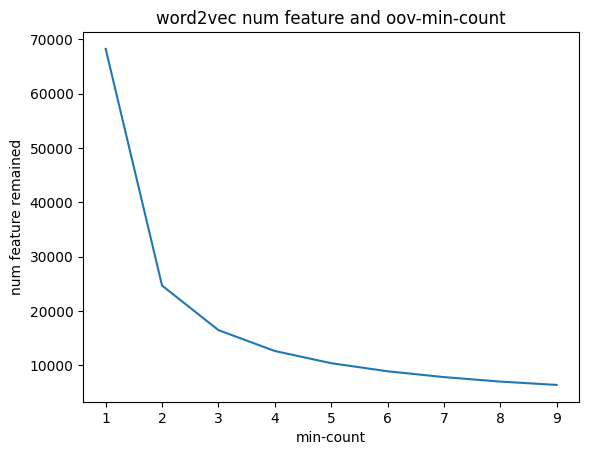

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df_shape_dict.keys(), df_shape_dict.values())
plt.title("word2vec num feature and oov-min-count")
plt.xlabel("min-count")
plt.ylabel("num feature remained")
plt.show()

In [ ]:
# we can see that at count 7, the feature almost stop appearant decreasing

w2v_model = w2v(
    df_total["cleaned_split"],
    min_count=7,  
    sg = 0,       
    window=5,
    vector_size = 200    
  )       

index = w2v_model.wv.key_to_index
embed_df = (
  pd.DataFrame(
    [w2v_model.wv.get_vector(str(n)) for n in index],
    index = index
  )
)

embed_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
movi,-0.191514,-0.436337,-0.296783,0.333632,0.421928,0.119092,0.068423,0.903913,-0.607213,0.189661,...,0.598940,0.144821,-0.628104,-0.336749,0.086460,0.091783,0.449574,-0.356052,-0.315862,-0.285372
film,-0.127454,-0.092136,-0.133792,0.241010,0.546738,0.028382,0.073335,0.628700,-0.481579,0.209890,...,0.414600,-0.012171,-0.411851,-0.202862,0.162294,0.217374,0.423222,-0.393750,-0.348910,-0.225611
one,-0.263222,-0.193139,-0.174485,0.184605,0.695620,0.125076,-0.083989,0.541790,-0.217610,0.185328,...,0.480011,0.029300,-0.448774,-0.079177,0.376615,0.399103,0.346489,-0.366514,-0.272005,-0.181502
veri,0.175539,0.111812,-0.243730,0.433716,0.608385,-0.295173,0.278522,0.523639,-0.516934,0.222452,...,0.316010,-0.378213,-0.389610,-0.140883,0.089697,0.216247,0.385697,-0.437372,-0.168394,-0.327474
there,0.012012,-0.021640,-0.613006,0.586693,0.181870,0.079141,0.157264,0.656052,-0.175634,0.336529,...,0.516852,0.049300,-0.352872,-0.367097,-0.152947,-0.144397,0.451553,-0.224533,-0.014296,-0.442910


In [ ]:
# if a sentence has this word, then include it into this sentence's vector
words = set(w2v_model.wv.index_to_key)
X_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in df_total["cleaned_split"]])

<ipython-input-160-a121dffffd89>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in df_total["cleaned_split"]])


In [ ]:
# see sentence length
count = 0
for i, v in enumerate(X_vect):
  print(len(df_total["cleaned_split"].iloc[i]), len(v))
  if count == 10:
    break
  count += 1

# the sentence length doesn't match and vector value count different
# need to adjust to same min length to do ml model classification

89 79
320 281
68 58
70 55
27 21
47 36
362 294
115 94
44 32
79 71
89 78


In [ ]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence

X_vect_avg = []
for vector in X_vect:
  # print(len(vector))
  # print(vector)
  # print(vector.mean())
  if vector.size != 0:
      X_vect_avg.append(vector.mean(axis=0))
  else:
      X_vect_avg.append(np.zeros(100))

In [ ]:
count = 0
for i, v in enumerate(X_vect_avg):
  print(len(df_total["cleaned_split"].iloc[i]), len(v))
  if count == 10:
    break
  count += 1

89 200
320 200
68 200
70 200
27 200
47 200
362 200
115 200
44 200
79 200
89 200


In [ ]:
len(X_vect_avg)

4004

In [ ]:
X_train_wv = X_vect_avg[:len(train_sent_df.index)+len(train_sent_df.index)//2]
X_test_wv = X_vect_avg[len(train_sent_df.index)+len(train_sent_df.index)//2:(len(train_sent_df.index)+len(test_sent_df.index))]
X_aspect_wv = X_vect_avg[len(train_sent_df.index)+len(test_sent_df.index):]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

def search_best_knn_2(loop_i):
  knn_clf = KNeighborsClassifier()

  # search space
  space = dict()
  space["n_neighbors"] = [10,20,40,70,100,200,500]
  space["algorithm"] = ['auto','ball_tree', 'kd_tree', 'brute']
  space["leaf_size"] = [10,30,50]

  # search
  search = GridSearchCV(knn_clf,space)

  result = search.fit(X_train_wv, Y_train[loop_i])
  print('Best Score: %s' % result.best_score_)
  print('Best Hyperparameters: %s' % result.best_params_)
  return (result.best_params_["n_neighbors"],result.best_params_["algorithm"],result.best_params_["leaf_size"])

knn_output = list()
for y in range(len(Y_train)):
  neighbors, alg, leaf = search_best_knn_2(y)
  knn_clf = KNeighborsClassifier(n_neighbors=neighbors, algorithm=alg, leaf_size=leaf)
  knn_clf.fit(X_train_wv, Y_train[y])
  output_single_knn = knn_clf.predict(X_test_wv)
  knn_output.append(output_single_knn)

Best Score: 0.5766666666666668
Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 200}
Best Score: 0.922
Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 20}
Best Score: 0.923
Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 10}
Best Score: 0.8073333333333335
Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 20}
Best Score: 0.958
Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 10}


In [ ]:
output, answer = transfer_to_1d(Y_test,knn_output)
f1_score(answer,output,average="macro")

0.8170517152549143